In [1]:
import sys
import pandas as pd
import pathlib
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Data Loading

Change this constant and re-run to load a different source file. The file should be generated by the 'gatherTrace.sh' script.

In [2]:
# sourceFile = pathlib.Path('example.csv')
# sourceFile = pathlib.Path('data/mnist4Epoch.csv')
sourceFile = pathlib.Path('data/mnist4Epoch.csv')

In [3]:
fullDF = pd.read_csv(sourceFile, skiprows=[4], usecols=['Start', 'Duration', 'Size', 'Name'], dtype={'Start':float, 'Duration':float, 'Size':float, 'Name':str}, comment="=")

In [4]:
# Cleanup
#   All times will be ms
#   All sizes with be MB
# The CSV has the units as the second row

# Start times are in S, duration is already ms
fullDF['Start'] *= 1000

# Views

In [5]:
fullDF['isKern'] = fullDF['Size'].isnull()
kernDF = fullDF[ fullDF['isKern'] ]
memDF = fullDF[ ~fullDF['isKern'] ]

# derived stats that we can export at the end
results = {}

## Functions

In [6]:
def plotHistogram(pltDF, range, title="", xlabel='', ylabel=''):
    plt.hist(pltDF, weights=np.ones(len(pltDF)) / pltDF.size, range=range)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.show()

The following analyses include only information during the GPU-heavy phase of computation. There may be non-trivial activity before and after the GPU phase, but these are not included.

In [7]:
results['totalRuntime'] = (fullDF['Start'].iloc[-1] - fullDF['Start'].iloc[0]) + fullDF['Duration'].iloc[-1]

# Kernel Runtime Analysis

In [8]:
results['meanKernDur'] = kernDF['Duration'].mean()
results['medianKernDur'] = kernDF['Duration'].median()
results['totalKernDur'] = kernDF['Duration'].sum()

print("Mean Kernel Runtime: ", results['meanKernDur'], "ms")
print("Median Kernel Runtime: ", results['medianKernDur'], "ms")

Mean Kernel Runtime:  0.05269932388993669 ms
Median Kernel Runtime:  0.015968 ms


In [9]:
kernEnds = kernDF['Start'] + kernDF['Duration']
interKernTimes = kernDF['Start'] - kernEnds.shift(1)
results['meanTBetweenKern'] = interKernTimes.mean()
results['medianTBetweenKern'] = interKernTimes.median()
results['totalTBetweenKern'] = interKernTimes.sum()

print("Average time between kernel invocations: ", results['meanTBetweenKern'], "ms")
print("Median time between kernel invocations: ", results['medianTBetweenKern'], "ms")
print("Total time between kernel invocations: ", results['totalTBetweenKern'])
print("Total time during kernel invocations: ", results['totalKernDur'])

Average time between kernel invocations:  -0.007204774643285461 ms
Median time between kernel invocations:  0.0031200000012177043 ms
Total time between kernel invocations:  -8006.57239901277
Total time during kernel invocations:  58564.12624699997


In [10]:
results['noverlapingKern'] = interKernTimes[ interKernTimes < 0].size
print("Percent of kernels that overlap: ", (results['noverlapingKern'] / interKernTimes.size) * 100, "%")

Percent of kernels that overlap:  35.02512400025916 %


In [11]:
# this result is not accurate because there is significant overlap in kernels.
# We also don't know how much overlap there is between host and gpu execution.
# A more direct measurement using a different profiling method will be needed.
print("Fraction of runtime spent in GPU: ", results['totalKernDur'] / results['totalRuntime'])

Fraction of runtime spent in GPU:  1.1403515431980347


The first observation is that the runtime distribution is extremely skewed, the mean is very different than the median. We plot the histograms below for a clearer picture, but it seems that the majority of kernels run in the single-digit microseconds.

The next observation is that there is some overlap in kernels (although very small). This means that in at least some cases, the application is not waiting for the result of the previous kernel before issuing the next. Furthermore, the median time between invocations is 4us. This is about twice the median kernel runtime, which would indicate that there is typically ~2us of overhead or computation time between invocations. It would be interesting to understand what fraction of that time is PCI-E or driver overhead, and what is actual computation (this depends on the methodology used by nvprof). Considering that even system call overheads can be over 1us, and PCI-E has us-level latencies, we can conclude that even when we don't directly observe overlapping invocations, most likely are. Basically, if the invocation overhead is greater than the kernel duration, we would not see direct overlap, but the application would not have had time to do anything but immediately issue another invocation.

The final observation here is that the application has the GPU working most of the time (78% for resnet18). This doesn't preclude overlap in CPU and GPU execution. This dataset does not have enough information to determine actual CPU usage, we'll need more traditional profilers for that. Still, it's encouraging to see that the GPU has plenty of work to do.

## Distribution of Kernel Runtimes
Below we plot the histogram of kernel runtimes. As you can see, the distribution is extremely skewed (making the mean a pretty bad metric). The vast majority of kernels run in under 10us, with 50% running in ~1us. Only a few outliers run in 1-2ms. This is fairly concerning from a KaaS perspective since invocation overheads will be in O(1ms) ignoring data movement. However, as shown above, kernels are launched in batches, with significant overlap of start times and durations (they get queued up in the CUDA driver). More analysis is needed to understand this contribution, since the chain of uninterrupted kernels is the actual unit of deployment in a KaaS system. 

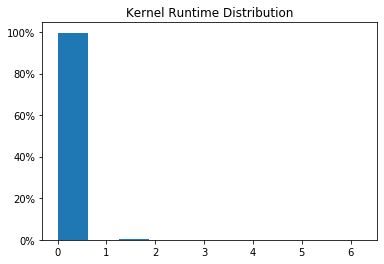

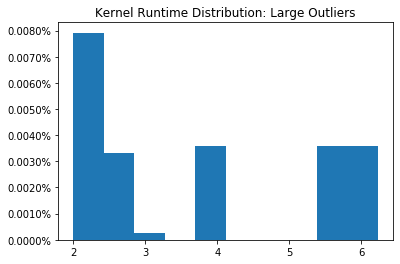

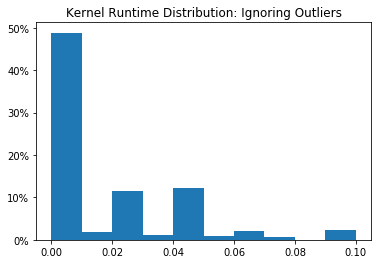

In [12]:
pltDF = kernDF['Duration']
def pltHist(pltDF, range, title=""):
    plt.hist(pltDF, weights=np.ones(pltDF.size) / pltDF.size, range=range)
    plt.xlabel('Kernel Duration in ms')
    plt.ylabel('Percent of Kernels')
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.show()
    
plotHistogram(pltDF, (0,pltDF.max()), "Kernel Runtime Distribution")
plotHistogram(pltDF, (2,pltDF.max()), "Kernel Runtime Distribution: Large Outliers")
plotHistogram(pltDF, (0,0.1), "Kernel Runtime Distribution: Ignoring Outliers")

In [13]:
del interKernTimes
del kernEnds

# Data Transfer Analysis

In [14]:
memcpySizes = memDF[ memDF['Name'] == '[CUDA memcpy HtoD]' ][['Size','Duration']]
results['h2dMeanSize'] = memcpySizes['Size'].mean()
results['h2dTotalSize'] = memcpySizes['Size'].sum()
results['h2dMeanTime'] = memcpySizes['Duration'].mean()
results['h2dTotalTime'] = memcpySizes['Duration'].sum()
print("Average memcpy H->D size: ", results['h2dMeanSize'], 'MB')
print("Total memcpy H->D size: ", results['h2dTotalSize'], 'MB')
print("Average memcpy H->D Duration: ", results['h2dMeanTime'], 'ms')
print("Percent of time spent in memcopy H->D:",(results['h2dTotalTime'] / results['totalRuntime'])*100)
del memcpySizes

Average memcpy H->D size:  0.005786095230933303 MB
Total memcpy H->D size:  846.3668659999997 MB
Average memcpy H->D Duration:  0.0029047034373376355 ms
Percent of time spent in memcopy H->D: 0.8273360735946508


In [15]:
memcpySizes = memDF[ memDF['Name'] == '[CUDA memcpy DtoH]' ][['Size','Duration']]
results['d2hMeanSize'] = memcpySizes['Size'].mean()
results['d2hTotalSize'] = memcpySizes['Size'].sum()
results['d2hMeanTime'] = memcpySizes['Duration'].mean()
results['d2hTotalTime'] = memcpySizes['Duration'].sum()
print("Average memcpy D->H size: ", results['d2hMeanSize'], 'MB')
print("Total memcpy D->H size: ", results['d2hTotalSize'], 'MB')
print("Average memcpy D->H Duration: ", results['d2hMeanTime'], 'ms')
print("Percent of time spent in memcopy D->H:",(results['d2hTotalTime'] / results['totalRuntime'])*100)
del memcpySizes

Average memcpy D->H size:  4.350877192982457e-06 MB
Total memcpy D->H size:  0.0019840000000000005 MB
Average memcpy D->H Duration:  0.0018321644736842102 ms
Percent of time spent in memcopy D->H: 0.001626808327546485


In [16]:
memEnds = memDF['Start'] + memDF['Duration']
interMemTimes = memDF['Start'] - memEnds.shift(1)
results['meanTBetweenMem'] = interMemTimes.mean()
results['medianTBetweenMem'] = interMemTimes.median()
results['totalTBetweenMem'] = interMemTimes.sum()

print("Average time between memory ops: ", results['meanTBetweenMem'], "ms")
print("Median time between memory opts: ", results['medianTBetweenMem'], "ms")
print("Percent of time between memory opts: ", (results['totalTBetweenMem'] / results['totalRuntime'])*100)

Average time between memory ops:  0.33011652357694377 ms
Median time between memory opts:  0.010168000000703614 ms
Percent of time between memory opts:  99.14319690208201


Data transfers are relatively low (at least for image recognition tasks). We also see that the total time spent on memory transfers is trivial relative to the total computation. This implies high computational intensity at the device level. The only remaining concern from a KaaS perspective is the interleaving of memory and kernel operations (discussed below).

# Interleaving of memory operations
When multiple kernels run without an intervening memory operation, we can assume that they communicate through device memory (or use the transparent memory paging). This value is a good indicator of how many kernels we could pack into a single KaaS invocation. These traces don't capture host-side execution, so we can't be sure what is happening in between kernel invocations. It's possible that non-trivial synchronization or other calculations are occuring between invocations which would limit the kernel chain size. I don't believe kernel invocation arguments are captured in these traces, so it's possible that the intervening code could be used to derive arguments.

In [17]:
# the group column assigns every row to a group, the cumsum increments the group every time the filter value
# changes (i.e. a run ends)
fullDF['runGroups'] = (fullDF['isKern'] != fullDF['isKern'].shift(1)).cumsum()
runCounts = fullDF['runGroups'].groupby(by=fullDF['runGroups'], sort=False).size()

results['meanKernRunLen'] = runCounts.mean()
results['medianKernRunLen'] = runCounts.median()
results['numKernRun'] = len(runCounts)
print("Mean run length:", results['meanKernRunLen'])
print("Median run length:", results['medianKernRunLen'])

Mean run length: 4.218405938646871
Median run length: 1.0


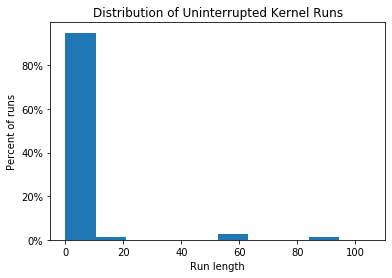

In [18]:
plotHistogram(runCounts, (0, runCounts.max()), title='Distribution of Uninterrupted Kernel Runs', xlabel='Run length', ylabel='Percent of runs')

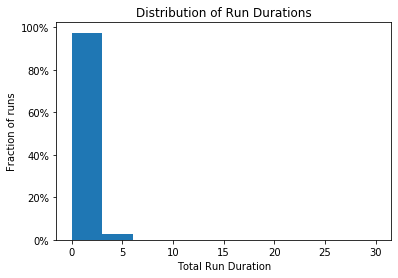

In [19]:
runDurations = fullDF[['Duration', 'runGroups']][fullDF['isKern']].groupby('runGroups').sum()['Duration']
plotHistogram(runDurations, (0,runDurations.max()), title='Distribution of Run Durations', xlabel='Total Run Duration', ylabel='Fraction of runs')

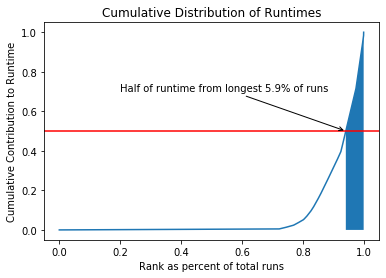

In [20]:
runDurations = runDurations.sort_values().reset_index(drop=True)
scaled = (runDurations.cumsum() / runDurations.sum())
scaled.index = scaled.index / scaled.index[-1]
scaled.plot()
plt.title("Cumulative Distribution of Runtimes")
plt.xlabel('Rank as percent of total runs')
plt.ylabel('Cumulative Contribution to Runtime')
plt.fill_between(scaled.index / scaled.index[-1], scaled, where=(scaled > 0.5))

plt.axhline(y=0.5, color='r')
halfWayPointX = scaled[scaled >= 0.5].index[0]
halfWayPointY = scaled[halfWayPointX]

plt.annotate("Half of runtime from longest {:.1f}% of runs".format((1 - halfWayPointX)*100), 
                (halfWayPointX, halfWayPointY), 
                xytext=(0.2, 0.7),
                arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.show()

While there is a long tail of short runs, the majority of time is spent in the longest ~10% of runs.

# Exporting Results

In [ ]:
resPath = 'results/' + sourceFile.stem + '.json'
with open(resPath, 'w') as f:
    f.write(json.dumps(results))
print("Results saved to: ", resPath)